In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences


from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)
pd.set_option('display.max_rows', None)


In [3]:
#the_office_df = pd.read_csv('the_office_series.csv')
friends_df = pd.read_csv('friends_episodes_3.csv', encoding='latin-1')

In [5]:
friends_df.head()

,Year_of_prod,Season,Episode Number,Episode_Title,Duration,Summary,Director,Stars,Votes
0,1994,1,1,The One Where Monica Gets a Roommate: The Pilot,22,"Monica and the gang introduce Rachel to the ""r...",James Burrows,8.3,7440
1,1994,1,2,The One with the Sonogram at the End,22,Ross finds out his ex-wife is pregnant. Rachel...,James Burrows,8.1,4888
2,1994,1,3,The One with the Thumb,22,Monica becomes irritated when everyone likes h...,James Burrows,8.2,4605
3,1994,1,4,The One with George Stephanopoulos,22,Joey and Chandler take Ross to a hockey game t...,James Burrows,8.1,4468
4,1994,1,5,The One with the East German Laundry Detergent,22,"Eager to spend time with Rachel, Ross pretends...",Pamela Fryman,8.5,4438


In [169]:
the_office_df.drop(['Unnamed: 0', 'GuestStars', 'Director', 'Writers'], axis=1, inplace=True)

In [170]:
the_office_df.head()

,Season,EpisodeTitle,About,Ratings,Votes,Viewership,Duration,Date
0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.2,23,24 March 2005
1,1,Diversity Day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.0,23,29 March 2005
2,1,Health Care,Michael leaves Dwight in charge of picking the...,7.8,4024,5.8,22,5 April 2005
3,1,The Alliance,"Just for a laugh, Jim agrees to an alliance wi...",8.1,3915,5.4,23,12 April 2005
4,1,Basketball,Michael and his staff challenge the warehouse ...,8.4,4294,5.0,23,19 April 2005


In [6]:
X = friends_df["Summary"].values
y = friends_df["Stars"].values

In [171]:
#X = the_office_df["About"].values
#y = the_office_df["Ratings"].values

In [7]:
y.shape


(236,)

In [8]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

In [9]:
for token in list(tokenizer.word_index)[:5]:
    print(f"word: '{token}', token: {tokenizer.word_index[token]}")

word: 'to', token: 1
word: 'and', token: 2
word: 'a', token: 3
word: 'the', token: 4
word: 'rachel', token: 5


In [10]:
X_seq = tokenizer.texts_to_sequences(X)

In [11]:
print("**Text comment**")
print({X[0]})

**Text comment**
{'Monica and the gang introduce Rachel to the "real world" after she leaves her fiancé at the altar.'}


In [12]:
print("**Numerical sequence representation**")
print(X_seq[0])

**Numerical sequence representation**
[7, 2, 4, 33, 411, 5, 1, 4, 412, 413, 29, 19, 142, 12, 661, 22, 4, 414]


In [13]:
max_words = 140

# Pad the sequences using the pad_sequences() method
X_pad = pad_sequences(X_seq, maxlen=max_words, padding="post")

In [44]:
scaler = MinMaxScaler()

In [45]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_pad, y)

X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_rnn, y_train_rnn)

In [223]:
# X_train_rnn = X_train_rnn.reshape((X_train_rnn.shape[0], X_train_rnn.shape[1], 1))
# X_test_rnn = X_test_rnn.reshape((X_test_rnn.shape[0], X_test_rnn.shape[1], 1))

In [48]:
scaler.fit(y)
y_train_rnn = scaler.transform(y_train_rnn)
y_test_rnn = scaler.transform(y_test_rnn)

In [61]:
X_test_rnn

array([[  9,  13, 654, ...,   0,   0,   0],
       [  7, 272, 150, ...,   0,   0,   0],
       [  5,  25,   1, ...,   0,   0,   0],
       ...,
       [ 21,   4, 132, ...,   0,   0,   0],
       [ 10,   2,   9, ...,   0,   0,   0],
       [  9, 500,   1, ...,   0,   0,   0]], dtype=int32)

In [49]:
vocabulary_size = len(tokenizer.word_counts.keys()) + 1
embedding_size = 64

In [50]:
# Define the LSTM RNN model
model = Sequential()

# Layer 1
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

# Layer 2
model.add(LSTM(units=280))

# Output layer
model.add(Dense(units=1, activation="sigmoid"))

In [51]:
# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 140, 64)           107584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 280)               386400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 281       
Total params: 494,265
Trainable params: 494,265
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Training the model
batch_size = 1000
epochs = 10
model.fit(
    X_train_rnn,
    y_train_rnn,
    validation_data=(X_val_rnn, y_val_rnn),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.6932 - accuracy: 0.0000e+00 - tp: 0.0000e+00 - tn: 0.0000e+00 - fp: 0.0000e+00 - fn: 132.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 0.6918 - val_accuracy: 0.0000e+00 - val_tp: 45.0000 - val_tn: 0.0000e+00 - val_fp: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.6933 - accuracy: 0.0000e+00 - tp: 132.0000 - tn: 0.0000e+00 - fp: 0.0000e+00 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 0.0000e+00 - val_loss: 0.6921 - val_accuracy: 0.0000e+00 - val_tp: 45.0000 - val_tn: 0.0000e+00 - val_fp: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.6931 - accuracy: 0.0000e+00 - tp: 132.0000 - tn: 0.0000e+00 - fp: 0.0000e+00 - fn: 0.0000e+00

In [32]:
model.evaluate(X_test_rnn, y_test_rnn)

2/2 [==============================] - 0s 132ms/step - loss: 0.6925 - accuracy: 0.0169 - tp: 59.0000 - tn: 0.0000e+00 - fp: 0.0000e+00 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 0.0000e+00


[0.6924936771392822, 0.016949152573943138, 59.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]

In [54]:
# Predict classes using the testing data
y_rnn_pred = model.predict_classes(X_test_rnn, batch_size=1000) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [55]:
predicted_ratings = scaler.inverse_transform(y_rnn_pred)
real_ratings = (y_test_rnn.reshape(-1, 1))

In [56]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_rnn, predicted_ratings)

0.3101016949152544

In [57]:
ratings = pd.DataFrame({
    "Real": real_ratings.ravel(),
    "Predicted": predicted_ratings.ravel()
}, index = friends_df.index[-len(real_ratings): ]) 
ratings.head()

,Real,Predicted
177,0.36,1.0
178,0.84,1.0
179,0.56,1.0
180,0.24,1.0
181,0.40,1.0


In [38]:
print("RNN Accuracy: %.2f" % (accuracy_score(y_test_rnn, y_rnn_pred)))

ValueError: ignored

In [3]:
x = pd.read_csv('multiTimeline.csv',header=1)
x = x.replace('<',0, regex=True)
# x = x.astype(int)
# x.plot(figsize=(30,15))
# x
x[['American Vandal: (United States)', 'Indebted: (United States)']].astype(int).sum()


American Vandal: (United States)    941
Indebted: (United States)           174
dtype: int64

In [4]:
tv_shows = pd.read_csv('tv_shows.csv',usecols=['Title','Year','Age','IMDb','Rotten Tomatoes','Netflix']).dropna().reset_index()
tv_shows = tv_shows.drop(columns='index')
tv_shows.columns = ['Title', 'Year', 'Age', 'IMDb', 'Rotten Tomatoes (%)','Netflix']
tv_shows['Rotten Tomatoes (%)'] = tv_shows['Rotten Tomatoes (%)'].replace('%','', regex=True)
tv_shows['Rotten Tomatoes (%)'] = tv_shows['Rotten Tomatoes (%)'].astype(int)
# tv_shows.Title == 'The Office'
# tv_shows_NF = tv_shows[tv_shows.Netflix == 1]
# tv_shows_NF = tv_shows[tv_shows.Year == 2020]
# tv_shows_NF = tv_shows.drop(tv_shows.Netflix == 0)
tv_shows = tv_shows[tv_shows.Netflix == 1]
tv_shows = tv_shows[tv_shows.Year == 2020]
tv_shows = tv_shows.sort_values(by='IMDb', ascending=False)
tv_shows = tv_shows.reset_index().drop(columns='index')
tv_shows.head(100)


tv_shows.loc[tv_shows['Title']=='Cheer']


,Title,Year,Age,IMDb,Rotten Tomatoes (%),Netflix
3,Cheer,2020,16+,8.2,96,1


In [5]:
shows_2020 = tv_shows[tv_shows.Year == 2020].reset_index()
shows_2019 = tv_shows[tv_shows.Year == 2019].reset_index()
shows_2018 = tv_shows[tv_shows.Year == 2018].reset_index()
shows_2017 = tv_shows[tv_shows.Year == 2017].reset_index()
shows_2016 = tv_shows[tv_shows.Year == 2016].reset_index()

In [6]:
shows_2020 = shows_2020.sort_values(by='IMDb', ascending=False)
shows_2020.sample(10)

,index,Title,Year,Age,IMDb,Rotten Tomatoes (%),Netflix
27,27,The Letter for the King,2020,7+,5.9,58,1
3,3,Cheer,2020,16+,8.2,96,1
19,19,The Eddy,2020,18+,7.0,68,1
23,23,Freud,2020,18+,6.6,50,1
22,22,Dracula,2020,18+,6.8,74,1
21,21,Cooked With Cannabis,2020,18+,6.9,80,1
20,20,How to Fix a Drug Scandal,2020,18+,6.9,86,1
18,18,Into the Night,2020,18+,7.2,83,1
10,10,Outer Banks,2020,18+,7.6,72,1
25,25,October Faction,2020,18+,6.1,33,1


In [7]:
recent_5 = pd.concat([shows_2020,
shows_2019,
shows_2018,
shows_2017,
shows_2016],).reset_index().drop(columns=['index','level_0'])
recent_5.Title.value_counts().sample(10)

How to Fix a Drug Scandal                     1
The Midnight Gospel                           1
Into the Night                                1
Killer Inside: The Mind of Aaron Hernandez    1
The Stranger                                  1
Tiger King: Murder, Mayhem and Madness        1
The Letter for the King                       1
Locke & Key                                   1
Hollywood                                     1
Brews Brothers                                1
Name: Title, dtype: int64

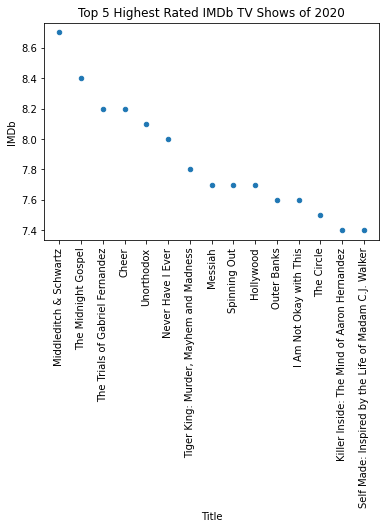

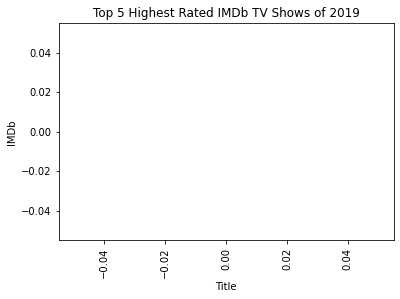

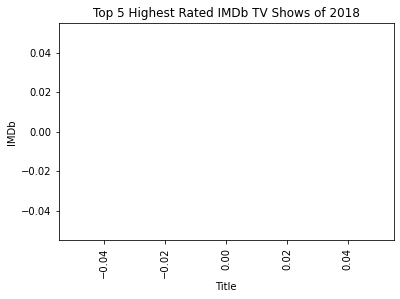

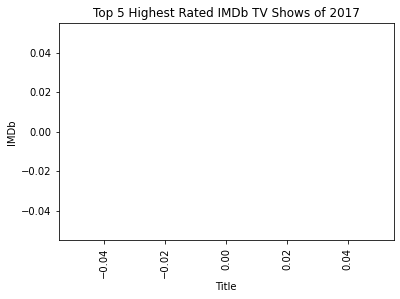

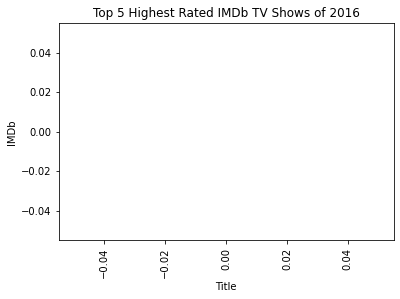

In [8]:
shows_2020.sort_values(by='IMDb',ascending=False).head(15).plot.scatter(x='Title',y='IMDb',title='Top 5 Highest Rated IMDb TV Shows of 2020', rot=90),
shows_2019.sort_values(by='IMDb',ascending=False).head(15).plot.scatter(x='Title',y='IMDb',title='Top 5 Highest Rated IMDb TV Shows of 2019', rot=90),
shows_2018.sort_values(by='IMDb',ascending=False).head(15).plot.scatter(x='Title',y='IMDb',title='Top 5 Highest Rated IMDb TV Shows of 2018', rot=90),
shows_2017.sort_values(by='IMDb',ascending=False).head(15).plot.scatter(x='Title',y='IMDb',title='Top 5 Highest Rated IMDb TV Shows of 2017', rot=90),
shows_2016.sort_values(by='IMDb',ascending=False).head(15).plot.scatter(x='Title',y='IMDb',title='Top 5 Highest Rated IMDb TV Shows of 2016', rot=90)

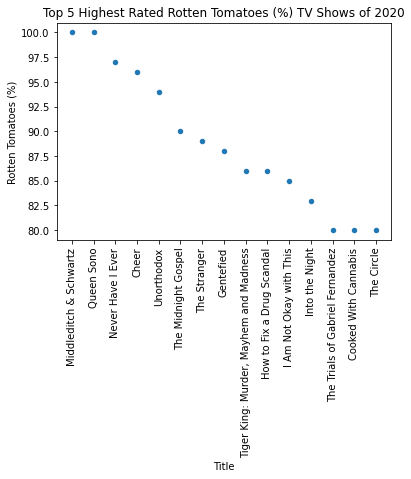

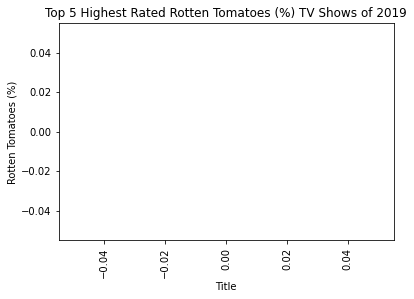

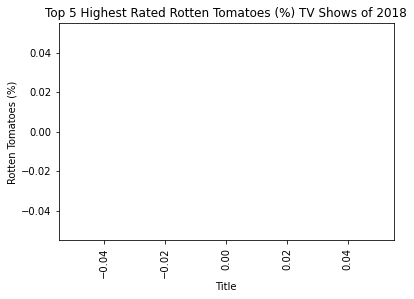

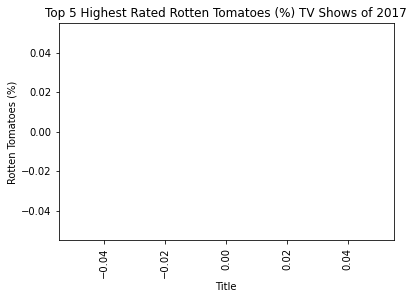

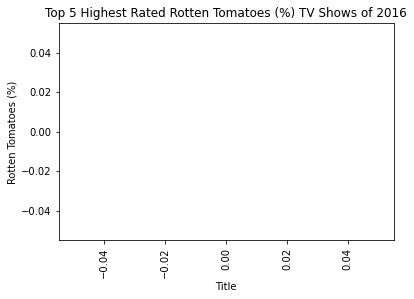

In [9]:
shows_2020.sort_values(by='Rotten Tomatoes (%)',ascending=False).head(15).plot.scatter(x='Title',y='Rotten Tomatoes (%)',title='Top 5 Highest Rated Rotten Tomatoes (%) TV Shows of 2020', rot=90),
shows_2019.sort_values(by='Rotten Tomatoes (%)',ascending=False).head(15).plot.scatter(x='Title',y='Rotten Tomatoes (%)',title='Top 5 Highest Rated Rotten Tomatoes (%) TV Shows of 2019', rot=90),
shows_2018.sort_values(by='Rotten Tomatoes (%)',ascending=False).head(15).plot.scatter(x='Title',y='Rotten Tomatoes (%)',title='Top 5 Highest Rated Rotten Tomatoes (%) TV Shows of 2018', rot=90),
shows_2017.sort_values(by='Rotten Tomatoes (%)',ascending=False).head(15).plot.scatter(x='Title',y='Rotten Tomatoes (%)',title='Top 5 Highest Rated Rotten Tomatoes (%) TV Shows of 2017', rot=90),
shows_2016.sort_values(by='Rotten Tomatoes (%)',ascending=False).head(15).plot.scatter(x='Title',y='Rotten Tomatoes (%)',title='Top 5 Highest Rated Rotten Tomatoes (%) TV Shows of 2016', rot=90)

In [10]:
# tv_shows[tv_shows['Title'] == 'Breaking Bad']
# tv_shows.Year.value_counts()
# yr_db = tv_shows[['Year','IMDb']]
# yr_db[yr_db['Year'] == 2020].tail().IMDb.sort_values(ascending=True).dropna().plot.bar(y='IMDb',figsize=(30,15))

In [15]:
sent = pd.read_csv('the_office_series.csv', usecols=['EpisodeTitle','About'])

In [19]:
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [20]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

lemmatizer = WordNetLemmatizer()
sw = set(stopwords.words('english')) 

from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]


def tokenizer(text):
    """Tokenizes text."""
    
    # Convert the words to lowercase
    regex = re.compile("[^a-zA-Z ]")
    
    # Remove the punctuation from text
    re_clean = regex.sub('', text)

    # Create a tokenized list of the words
    words = word_tokenize(re_clean)
    
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
       
    # Remove the stop words
    tokens = [word.lower() for word in lem if word.lower() not in sw]
    
    return tokens

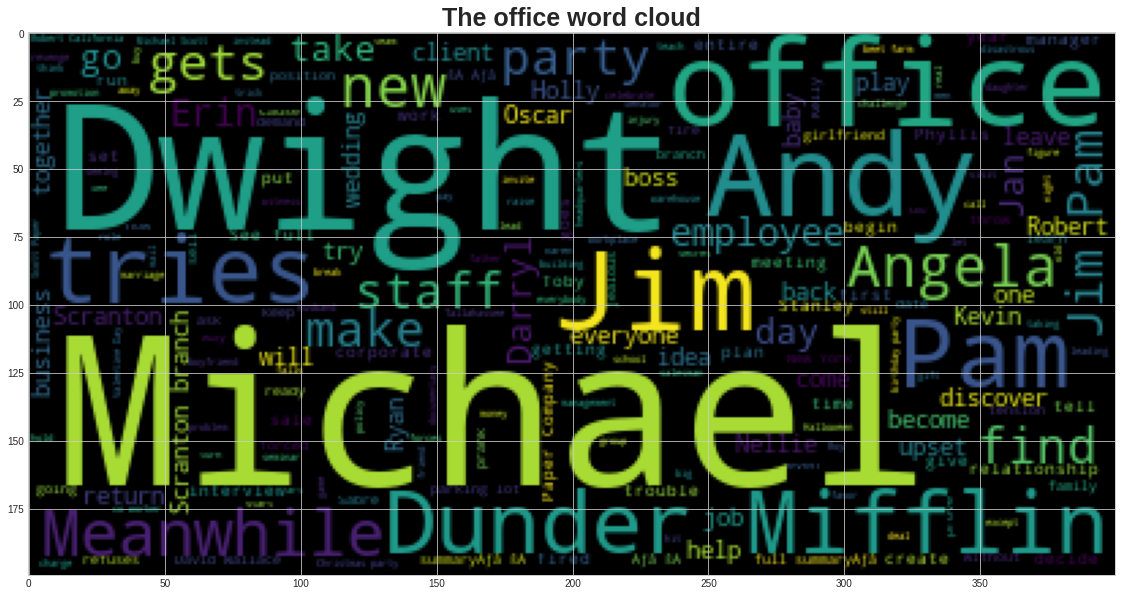

In [21]:
sent['tokens'] = sent['About'].apply(tokenizer)
sent_string = ' '.join(sent.About)

wc = WordCloud().generate(sent_string)
plt.title('The office word cloud', fontsize=25, fontweight='bold')
plt.imshow(wc)

In [41]:
the_office_df.drop(['Unnamed: 0', 'GuestStars', 'Director', 'Writers'], axis=1, inplace=True)


In [42]:
the_office_df.head()

,Season,EpisodeTitle,About,Ratings,Votes,Viewership,Duration,Date
0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.2,23,24 March 2005
1,1,Diversity Day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.0,23,29 March 2005
2,1,Health Care,Michael leaves Dwight in charge of picking the...,7.8,4024,5.8,22,5 April 2005
3,1,The Alliance,"Just for a laugh, Jim agrees to an alliance wi...",8.1,3915,5.4,23,12 April 2005
4,1,Basketball,Michael and his staff challenge the warehouse ...,8.4,4294,5.0,23,19 April 2005


In [32]:
the_office_df.head()

,Unnamed: 0,Season,EpisodeTitle,About,Ratings,Votes,Viewership,Duration,Date
0,0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.2,23,24 March 2005
1,1,1,Diversity Day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.0,23,29 March 2005
2,2,1,Health Care,Michael leaves Dwight in charge of picking the...,7.8,4024,5.8,22,5 April 2005
3,3,1,The Alliance,"Just for a laugh, Jim agrees to an alliance wi...",8.1,3915,5.4,23,12 April 2005
4,4,1,Basketball,Michael and his staff challenge the warehouse ...,8.4,4294,5.0,23,19 April 2005
